In [9]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

# Bank Customer Segmentation Analysis - Student Exercise

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [19]:
# Load Data and Preprocess
def load_data(filepath):
    df = pd.read_csv('bank-full.csv')

    # Identify categorical and numerical columns
    categorical_cols = df.select_dtypes(include=['object']).columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    # Encode categorical variables
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

    # Scale numerical features
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

    return df

#================ FOR PCA Dimensionality reduction =========
# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components):
    pca = PCA(n_components=n_components)
    return pca.fit_transform(x)

#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method)
def find_optimal_clusters(x, max_clusters=10):
    inertias = []
    for k in range(1, max_clusters + 1):
        km = KMeansClustering(n_clusters=k)
        km.fit(x)
        inertias.append(calculate_inertia(x, km.labels, km.centroids))
    return inertias

# Perform KMeans Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    km = KMeansClustering(n_clusters=n_clusters)
    km.fit(x)
    return km

#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering
# Change None to the number of n_clusters value from the elbow method
def perform_agglomerative_clustering(x, n_clusters=None):
    from sklearn.cluster import AgglomerativeClustering
    model = AgglomerativeClustering(n_clusters=n_clusters)
    return model.fit_predict(x)

#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    from scipy.cluster.hierarchy import linkage
    return linkage(x, method='ward')

# Plot Dendrogram
def plot_dendrogram(linked):
    from scipy.cluster.hierarchy import dendrogram
    plt.figure(figsize=(12, 4))
    dendrogram(linked)
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

In [13]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.

    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Your code here:
    # Load data
    df = pd.read_csv(filepath, sep=';')
    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                       'loan', 'contact', 'month', 'poutcome', 'y']

    # TODO: Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])
    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education',
               'housing', 'loan', 'default']
    X = df[features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

Data shape: (45211, 9)


In [14]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        np.random.seed(self.random_state)
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        dists = np.linalg.norm(X[:, None, :] - self.centroids[None, :, :], axis=2)
        return np.argmin(dists, axis=1)

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        TODO (student):
        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        centroids = []
        for i in range(self.n_clusters):
          pts = X[labels == i]
          if len(pts) == 0:
            centroids.append(self.centroids[i])
          else:
            centroids.append(pts.mean(axis=0))
        return np.vstack(centroids)

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        TODO (student):
        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        self.centroids = self._initialize_centroids(X)
        for _ in range(self.max_iters):
          labels = self._assign_clusters(X)
          new_centroids = self._update_centroids(X, labels)
          if np.allclose(self.centroids, new_centroids):
            break
          self.centroids = new_centroids
        self.labels = labels
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)


## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

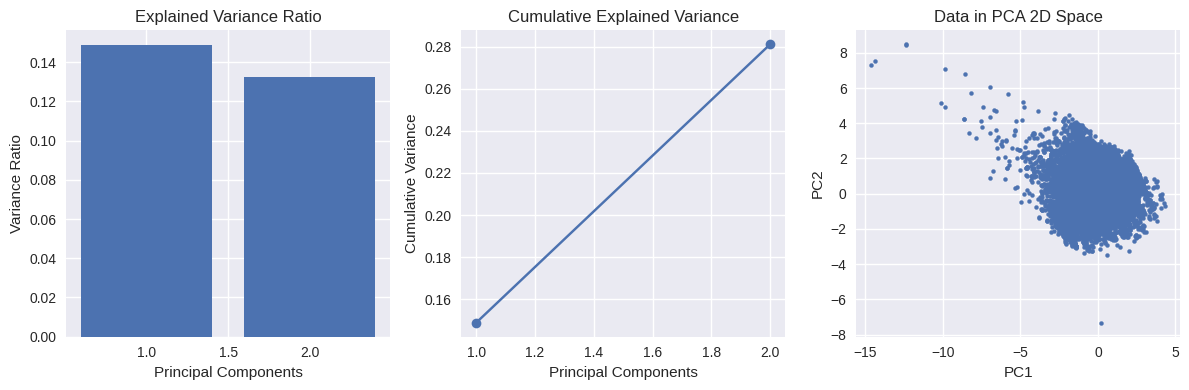

Shape after PCA: (45211, 2)


In [27]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.

    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # TODO: Create visualization
    plt.figure(figsize=(12, 4))

    # Explained variance ratio
    plt.subplot(1, 3, 1)
    plt.bar(range(1, n_components + 1), pca.explained_variance_ratio_)
    plt.title("Explained Variance Ratio")
    plt.xlabel("Principal Components")
    plt.ylabel("Variance Ratio")

    # Cumulative explained variance
    plt.subplot(1, 3, 2)
    cumulative = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, n_components + 1), cumulative, marker='o')
    plt.title("Cumulative Explained Variance")
    plt.xlabel("Principal Components")
    plt.ylabel("Cumulative Variance")

    # Data distribution in 2D
    plt.subplot(1, 3, 3)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=8)
    plt.title("Data in PCA 2D Space")
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.tight_layout()
    plt.show()

    return X_pca

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

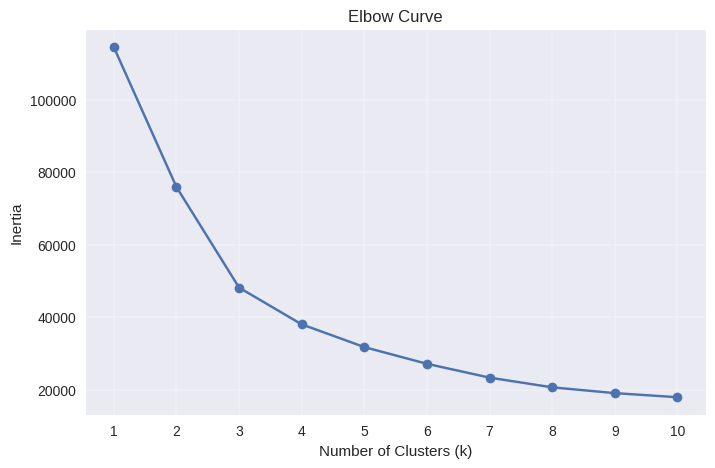

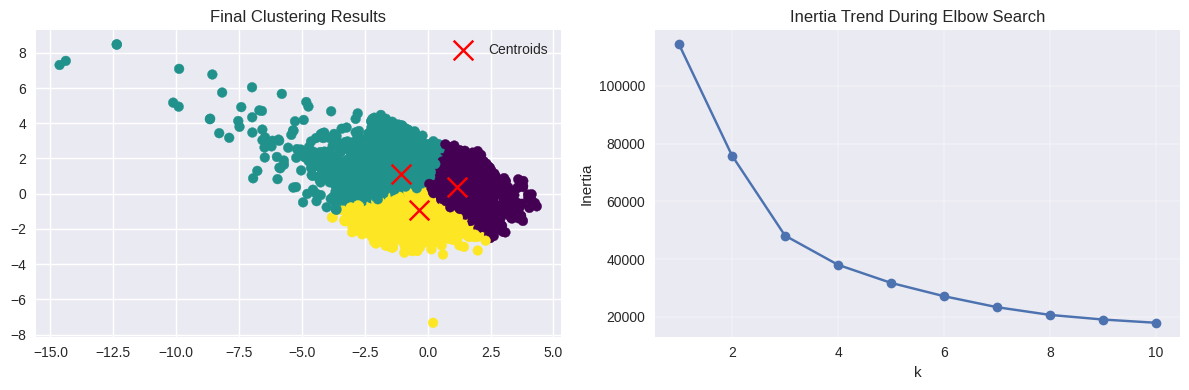


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [29]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia).

    TODO:
    1. For each cluster, calculate the sum of squared distances
       between points and their centroid
    2. Sum up all cluster distances
    """
    # Your code here
    inertia = 0
    for k in range(centroids.shape[0]):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[k])**2)
    return inertia


def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters.

    TODO:
    1. Try different values of k (1 to max_k)
    2. Calculate inertia for each k
    3. Plot k vs inertia
    4. Help identify the 'elbow' point
    """
    # Your code here
    inertias = []
    K = range(1, max_k + 1)

    for k in K:
        model = KMeansClustering(n_clusters=k)
        model.fit(X)
        inertia_k = calculate_inertia(X, model.labels, model.centroids)
        inertias.append(inertia_k)

    # Create elbow plot
    plt.figure(figsize=(8, 5))
    plt.plot(K, inertias, marker='o')
    plt.title("Elbow Curve")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia")
    plt.xticks(K)
    plt.grid(True, linewidth=0.3)
    plt.show()

    return inertias


# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1],
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Plot evaluation metrics
plt.subplot(1, 2, 2)
plt.plot(range(1, len(inertias) + 1), inertias, marker='o')
plt.title("Inertia Trend During Elbow Search")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True, linewidth=0.3)

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.

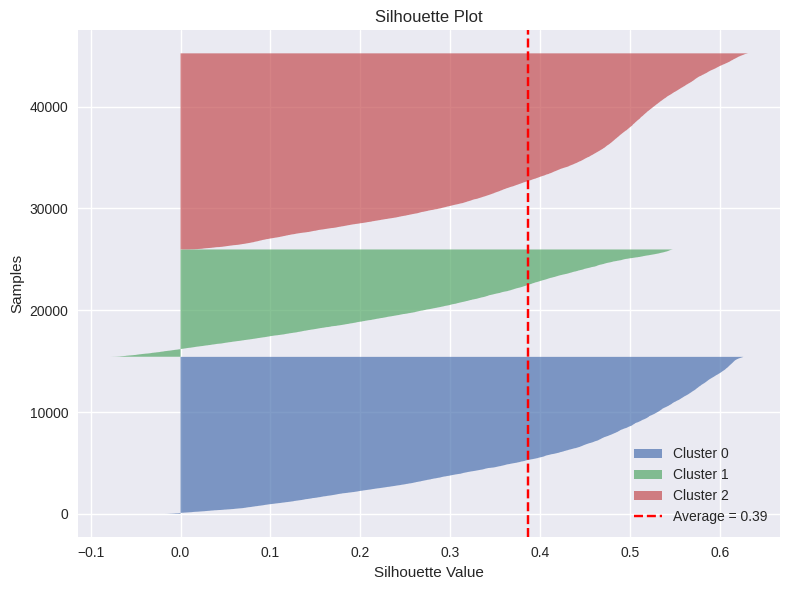

Silhouette Score: 0.386652529096419


In [30]:
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import matplotlib.pyplot as plt

def plot_silhouette(X, labels):
    sil_values = silhouette_samples(X, labels)
    avg_score = np.mean(sil_values)
    n_clusters = len(np.unique(labels))

    plt.figure(figsize=(8, 6))
    y_lower = 10

    for i in range(n_clusters):
        cluster_sil = sil_values[labels == i]
        cluster_sil.sort()
        size_i = cluster_sil.shape[0]
        y_upper = y_lower + size_i

        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            cluster_sil,
            alpha=0.7,
            label=f"Cluster {i}"
        )

        y_lower = y_upper + 10

    plt.axvline(avg_score, color="red", linestyle="--", label=f"Average = {avg_score:.2f}")
    plt.xlabel("Silhouette Value")
    plt.ylabel("Samples")
    plt.title("Silhouette Plot")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return avg_score

# Generate the silhouette plot
silhouette_avg = plot_silhouette(X_pca, kmeans.labels)
print("Silhouette Score:", silhouette_avg)

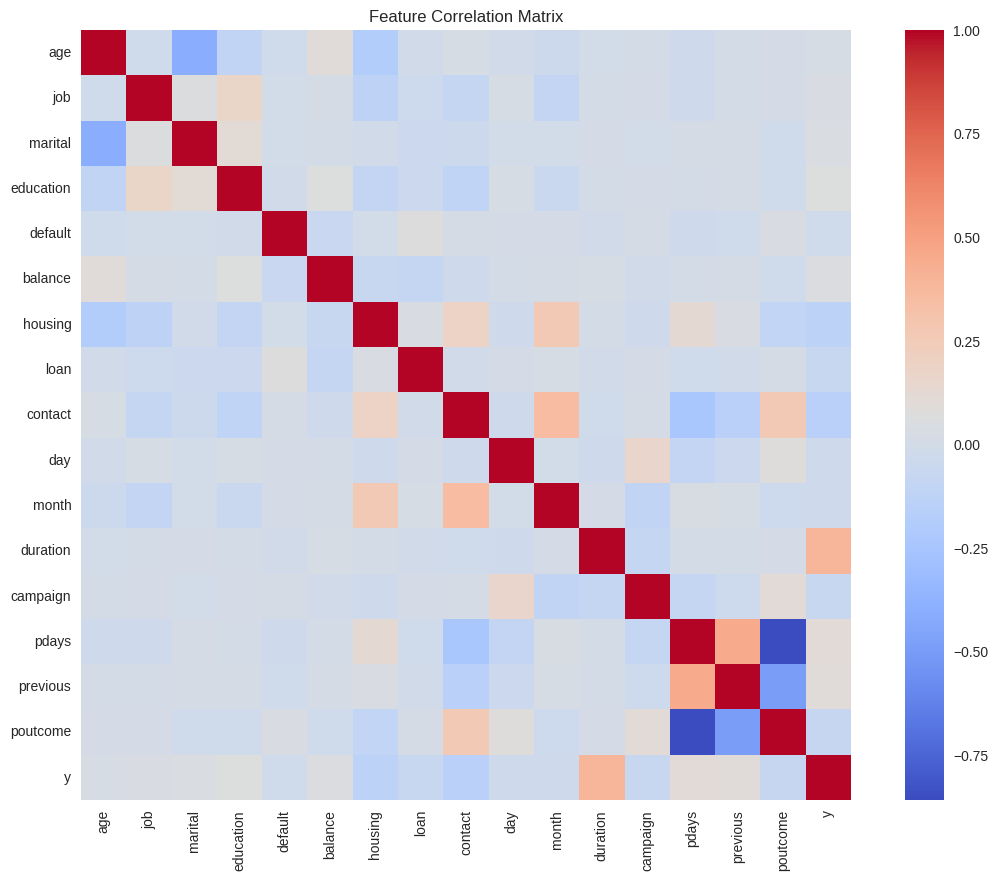

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr = data.corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True)
plt.title("Feature Correlation Matrix")
plt.show()

## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!